In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
df = pd.read_csv('Amazon_Beauty_Recommendation.csv')
df.head()

UserId   ProductId       ProductType  Rating   Timestamp  \
0  A3NHUQ33CFH3VM  B00LLPT4HI  Eyeliner & Kajal       5  1405814400   
1  A1TIRNQ7O4REOH  B00LLPT4HI  Eyeliner & Kajal       4  1405987200   
2  A2Y36BR4YSY9F7  B00LLPT4HI  Eyeliner & Kajal       5  1405728000   
3  A23H6FAOLEMAKC  B00LLPT4HI  Eyeliner & Kajal       5  1405814400   
4  A3CHYZGF3OO6WD  B00LLPT4HI  Eyeliner & Kajal       5  1405641600   

                                                 URL  
0  https://www.amazon.in/Maybelline-Colossal-Kaja...  
1  https://www.amazon.in/Maybelline-Colossal-Kaja...  
2  https://www.amazon.in/Maybelline-Colossal-Kaja...  
3  https://www.amazon.in/Maybelline-Colossal-Kaja...  
4  https://www.amazon.in/Maybelline-Colossal-Kaja...

In [3]:
print(df[['UserId', 'ProductId', 'Timestamp']].head())

           UserId   ProductId   Timestamp
0  A3NHUQ33CFH3VM  B00LLPT4HI  1405814400
1  A1TIRNQ7O4REOH  B00LLPT4HI  1405987200
2  A2Y36BR4YSY9F7  B00LLPT4HI  1405728000
3  A23H6FAOLEMAKC  B00LLPT4HI  1405814400
4  A3CHYZGF3OO6WD  B00LLPT4HI  1405641600


In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
print(df[['UserId', 'ProductId', 'Timestamp']].head())
print(df.shape)

           UserId   ProductId  Timestamp
0  A3NHUQ33CFH3VM  B00LLPT4HI 2014-07-20
1  A1TIRNQ7O4REOH  B00LLPT4HI 2014-07-22
2  A2Y36BR4YSY9F7  B00LLPT4HI 2014-07-19
3  A23H6FAOLEMAKC  B00LLPT4HI 2014-07-20
4  A3CHYZGF3OO6WD  B00LLPT4HI 2014-07-18
(1348246, 6)


In [5]:
user_counts = df['UserId'].value_counts()
filtered_users = user_counts[user_counts >= 5].index
df = df[df['UserId'].isin(filtered_users)]
print(f"Data after filtering: {df.shape}")

Data after filtering: (243601, 6)


In [6]:
item_counts = df['ProductId'].value_counts()
filtered_items = item_counts[item_counts >= 5].index
df = df[df['ProductId'].isin(filtered_items)]

print(f"Data after filtering: {df.shape}")

Data after filtering: (219119, 6)


In [7]:
user_encoder = LabelEncoder()
df['UserId'] = user_encoder.fit_transform(df['UserId'])+1
df['UserId'].max()

28035

In [8]:
item_encoder = LabelEncoder()
df['ProductId'] = item_encoder.fit_transform(df['ProductId']) + 1
df['ProductId'].max()

12704

In [9]:
num_items = df['ProductId'].max() + 1
print(f"Total number of items including padding index: {num_items}")

Total number of items including padding index: 12705


In [10]:
df = df.sort_values(['UserId', 'Timestamp']).reset_index(drop=True)
df.head()

UserId  ProductId          ProductType  Rating  Timestamp  \
0       1      12520  Shaving Foam & Gels       5 2014-07-14   
1       1      12421  Trimmers & Clippers       5 2014-07-14   
2       1      11836   Kits & Accessories       3 2014-07-14   
3       1      10802          Conditioner       1 2014-07-14   
4       1      10565          Conditioner       2 2014-07-14   

                                                 URL  
0  https://www.amazon.in/gp/slredirect/picassoRed...  
1  https://www.amazon.in/Philips-BT3215-Cordless-...  
2  https://www.amazon.in/SUGAR-POP-Exclusive-Esse...  
3  https://www.amazon.in/Garnier-Fructis-Strong-S...  
4  https://www.amazon.in/LOreal-Paris-RESIST-Cond...

In [11]:
user_sequences = df.groupby('UserId')['ProductId'].apply(list).values
print(user_sequences[:5])
print(len(user_sequences))

[list([12520, 12421, 11836, 10802, 10565, 10186])
 list([3694, 9806, 5040, 4580, 11636, 55])
 list([6985, 4850, 4661, 9396, 6227, 492, 10974, 10137])
 list([10861, 9692, 9564, 9397, 10880, 10498, 3890])
 list([9662, 11043, 10892, 9089, 8810, 5610, 10951, 9564])]
28035


In [12]:
if (df['ProductId'] == 0).any():
    print("The encoder assigned 0 as a value for some ProductId entries.")
else:
    print("No ProductId entry has been assigned the value 0.")


No ProductId entry has been assigned the value 0.


In [13]:
def generate_sequences(sequence, window_size=10):
    if len(sequence) < window_size:
        sequence = [0] * (window_size - len(sequence)) + sequence
    return [sequence[i:i + window_size] for i in range(len(sequence) - window_size + 1)]

In [14]:
all_sequences = []
for seq in user_sequences:
    all_sequences.extend(generate_sequences(seq))
print(len(all_sequences))

67761


In [15]:
print(all_sequences[:20])

[[0, 0, 0, 0, 12520, 12421, 11836, 10802, 10565, 10186], [0, 0, 0, 0, 3694, 9806, 5040, 4580, 11636, 55], [0, 0, 6985, 4850, 4661, 9396, 6227, 492, 10974, 10137], [0, 0, 0, 10861, 9692, 9564, 9397, 10880, 10498, 3890], [0, 0, 9662, 11043, 10892, 9089, 8810, 5610, 10951, 9564], [0, 0, 0, 0, 0, 6643, 5649, 4783, 1095, 856], [10610, 4019, 4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122], [4019, 4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122, 9928], [4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122, 9928, 8149], [0, 0, 0, 0, 0, 0, 11348, 11082, 11597, 11803], [0, 0, 0, 0, 11614, 10582, 10498, 10363, 10323, 7219], [0, 0, 0, 5906, 496, 4734, 2710, 4183, 3283, 3438], [0, 0, 0, 0, 652, 1347, 1046, 8589, 8108, 3266], [7817, 8269, 4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336], [8269, 4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958], [4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958, 9353], [3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958, 9353, 11083], [10986, 10303, 8594, 7245, 4

In [16]:
all_sequences = torch.tensor(all_sequences, dtype=torch.long)
inputs = all_sequences[:, :-1]
targets = all_sequences[:, -1]

In [17]:
print(inputs)


tensor([[    0,     0,     0,  ..., 11836, 10802, 10565],
        [    0,     0,     0,  ...,  5040,  4580, 11636],
        [    0,     0,  6985,  ...,  6227,   492, 10974],
        ...,
        [ 6122,  5562,  5362,  ...,  9933,  8364,  6481],
        [    0,     0,     0,  ..., 11713, 10830,  7269],
        [    0,     0,     0,  ...,  9392,  9265,  7728]])


In [18]:
print(inputs[:20])

tensor([[    0,     0,     0,     0, 12520, 12421, 11836, 10802, 10565],
        [    0,     0,     0,     0,  3694,  9806,  5040,  4580, 11636],
        [    0,     0,  6985,  4850,  4661,  9396,  6227,   492, 10974],
        [    0,     0,     0, 10861,  9692,  9564,  9397, 10880, 10498],
        [    0,     0,  9662, 11043, 10892,  9089,  8810,  5610, 10951],
        [    0,     0,     0,     0,     0,  6643,  5649,  4783,  1095],
        [10610,  4019,  4338,  9407,  8525,  8762,  6598,  3044,  9937],
        [ 4019,  4338,  9407,  8525,  8762,  6598,  3044,  9937,  5122],
        [ 4338,  9407,  8525,  8762,  6598,  3044,  9937,  5122,  9928],
        [    0,     0,     0,     0,     0,     0, 11348, 11082, 11597],
        [    0,     0,     0,     0, 11614, 10582, 10498, 10363, 10323],
        [    0,     0,     0,  5906,   496,  4734,  2710,  4183,  3283],
        [    0,     0,     0,     0,   652,  1347,  1046,  8589,  8108],
        [ 7817,  8269,  4328,  3350, 10986, 10303, 

In [19]:
print(targets)


tensor([10186,    55, 10137,  ...,  2814,  7351,  2347])


In [20]:
print(f'Inputs shape: {inputs.shape}, Targets shape: {targets.shape}')

Inputs shape: torch.Size([67761, 9]), Targets shape: torch.Size([67761])


In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split


dataset = TensorDataset(inputs, targets)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")


Train size: 47432
Validation size: 10164
Test size: 10165


In [22]:
for batch_inputs, batch_targets in train_loader:
    print(f'Batch Inputs: {batch_inputs.shape}, Batch Targets: {batch_targets.shape}')
    break

Batch Inputs: torch.Size([32, 9]), Batch Targets: torch.Size([32])


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

        assert embedding_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)

        self.out = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, E = x.size()

        Q = self.query(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        output = torch.matmul(attn, V)
        output = output.transpose(1, 2).contiguous().view(B, N, E)

        return self.out(output)

class PointWiseFeedForward(nn.Module):
    def __init__(self, embedding_dim, ff_dim, dropout=0.1):
        super(PointWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(embedding_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, embedding_dim)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        return self.linear2(x)

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.msa = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.ffn = PointWiseFeedForward(embedding_dim, ff_dim, dropout)

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.msa(self.norm1(x)))

        x = x + self.dropout(self.ffn(self.norm2(x)))

        return x

class UET4Rec(nn.Module):
    def __init__(self, num_items, embedding_dim=64, nhead=4, max_len=50, dropout=0.2, ff_dim=256):
        super(UET4Rec, self).__init__()

        self.item_embedding = nn.Embedding(num_items, embedding_dim, padding_idx=0)

        self.position_embedding = nn.Embedding(max_len, embedding_dim)

        self.encoder1 = nn.Sequential(
            nn.Conv1d(embedding_dim, embedding_dim // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv1d(embedding_dim // 2, embedding_dim // 4, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.encoder3 = nn.Sequential(
            nn.Conv1d(embedding_dim // 4, embedding_dim // 8, kernel_size=5, padding=2)
        )

        self.transformer = nn.ModuleList([
            CustomTransformerEncoderLayer(embedding_dim // 8, nhead, ff_dim, dropout) for _ in range(3)
        ])

        self.decoder1 = nn.Sequential(
            nn.Conv1d(embedding_dim // 8, embedding_dim // 4, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(embedding_dim // 4, embedding_dim // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(embedding_dim // 2, embedding_dim, kernel_size=5, padding=2)
        )

        self.fc = nn.Linear(embedding_dim, num_items)

    def forward(self, x):
        batch_size, seq_len = x.size()

        positions = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x = self.item_embedding(x) + self.position_embedding(positions)

        x = x.permute(0, 2, 1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        x = enc3.permute(0, 2, 1)
        for layer in self.transformer:
            x = layer(x)
        x = x.permute(0, 2, 1)

        dec1 = self.decoder1(x + enc3)
        dec2 = self.decoder2(dec1 + enc2)
        dec3 = self.decoder3(dec2 + enc1)
        x = dec3[:, :, -1]
        out = self.fc(x)

        return out


In [24]:
embedding_dim = 128
nhead = 4
ff_dim = 256
dropout = 0.2
max_len = 9

model = UET4Rec(
    num_items=num_items,
    embedding_dim=embedding_dim,
    nhead=nhead,
    max_len=max_len,
    dropout=dropout,
    ff_dim=ff_dim
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

UET4Rec(
  (item_embedding): Embedding(12705, 128, padding_idx=0)
  (position_embedding): Embedding(9, 128)
  (encoder1): Sequential(
    (0): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder2): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder3): Sequential(
    (0): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (transformer): ModuleList(
    (0-2): 3 x CustomTransformerEncoderLayer(
      (msa): MultiHeadSelfAttention(
        (query): Linear(in_features=16, out_features=16, bias=True)
        (key): Linear(in_features=16, out_features=16, bias=True)
        (value

In [25]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def clip_gradients(model, clip_value):
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.clamp_(-clip_value, clip_value)

num_epochs = 100
save_interval = 20

def adjust_learning_rate(optimizer, epoch, warmup_epochs=10, warmup_lr=0.005, main_lr=0.001):
    if epoch < warmup_epochs:
        lr = warmup_lr
    else:
        lr = main_lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def calculate_metrics(model, val_loader, ks=[5, 10, 20]):
    model.eval()
    total_hr = {k: 0 for k in ks}
    total_ndcg = {k: 0 for k in ks}
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            outputs = model(batch_inputs)
            _, top_k_indices = torch.topk(outputs, k=max(ks), dim=1)

            for i in range(batch_targets.size(0)):
                target = batch_targets[i].item()
                predictions = top_k_indices[i].cpu().numpy()

                for k in ks:
                    top_k_preds = predictions[:k]

                    if target in top_k_preds:
                        total_hr[k] += 1

                    if target in top_k_preds:
                        rank = np.where(top_k_preds == target)[0][0] + 1
                        total_ndcg[k] += 1 / np.log2(rank + 1)

            total_samples += batch_targets.size(0)

    hr = {k: total_hr[k] / total_samples for k in ks}
    ndcg = {k: total_ndcg[k] / total_samples for k in ks}

    return hr, ndcg

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    adjust_learning_rate(optimizer, epoch, warmup_epochs=10, warmup_lr=0.005, main_lr=0.001)

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as progress_bar:
        for batch_idx, (batch_inputs, batch_targets) in enumerate(progress_bar):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()

            outputs = model(batch_inputs)

            loss = criterion(outputs, batch_targets)

            loss.backward()

            clip_gradients(model, clip_value=1.0)

            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == batch_targets).sum().item()
            total_predictions += batch_targets.size(0)

            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    if (epoch + 1) % save_interval == 0:
        model_save_path = f"uet4rec128_beauty_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved after {epoch+1} epochs at '{model_save_path}'.")

        print("\nCalculating metrics...")
        hr, ndcg = calculate_metrics(model, val_loader, ks=[5, 10, 20])
        for k in [5, 10, 20]:
            print(f"HR@{k}: {hr[k]:.4f}, NDCG@{k}: {ndcg[k]:.4f}")

final_model_path = "uet4rec128_beauty_model_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved as '{final_model_path}'.")

print("Training Completed.")


Using device: cuda
Starting Training...


Epoch [1/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.67batch/s, Batch Loss=8.64]


Epoch [1/100], Training Loss: 8.7201, Accuracy: 0.0035


Epoch [2/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.27batch/s, Batch Loss=6.64]


Epoch [2/100], Training Loss: 7.9763, Accuracy: 0.0140


Epoch [3/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.00batch/s, Batch Loss=7.41]


Epoch [3/100], Training Loss: 7.4360, Accuracy: 0.0290


Epoch [4/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.65batch/s, Batch Loss=7.57]


Epoch [4/100], Training Loss: 6.2706, Accuracy: 0.0539


Epoch [5/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.70batch/s, Batch Loss=4.79]


Epoch [5/100], Training Loss: 4.4612, Accuracy: 0.1874


Epoch [6/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.18batch/s, Batch Loss=5.09]


Epoch [6/100], Training Loss: 2.9174, Accuracy: 0.4039


Epoch [7/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:42<00:00, 35.30batch/s, Batch Loss=3.91]


Epoch [7/100], Training Loss: 2.1055, Accuracy: 0.5356


Epoch [8/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:42<00:00, 34.93batch/s, Batch Loss=2.82]


Epoch [8/100], Training Loss: 1.6604, Accuracy: 0.6158


Epoch [9/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:46<00:00, 31.79batch/s, Batch Loss=2.61]


Epoch [9/100], Training Loss: 1.3923, Accuracy: 0.6682


Epoch [10/100]: 100%|██████████████████████████████████████████| 1483/1483 [00:47<00:00, 30.91batch/s, Batch Loss=3.68]


Epoch [10/100], Training Loss: 1.1993, Accuracy: 0.7056


Epoch [11/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.95batch/s, Batch Loss=0.322]


Epoch [11/100], Training Loss: 0.6695, Accuracy: 0.8256


Epoch [12/100]: 100%|████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.54batch/s, Batch Loss=0.0191]


Epoch [12/100], Training Loss: 0.5024, Accuracy: 0.8662


Epoch [13/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.18batch/s, Batch Loss=0.692]


Epoch [13/100], Training Loss: 0.4368, Accuracy: 0.8805


Epoch [14/100]: 100%|████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.68batch/s, Batch Loss=0.0457]


Epoch [14/100], Training Loss: 0.3883, Accuracy: 0.8922


Epoch [15/100]: 100%|███████████████████████████████████████| 1483/1483 [00:44<00:00, 33.01batch/s, Batch Loss=0.00683]


Epoch [15/100], Training Loss: 0.3595, Accuracy: 0.8984


Epoch [16/100]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.14batch/s, Batch Loss=0.0552]


Epoch [16/100], Training Loss: 0.3330, Accuracy: 0.9048


Epoch [17/100]: 100%|██████████████████████████████████████| 1483/1483 [00:47<00:00, 31.17batch/s, Batch Loss=0.000941]


Epoch [17/100], Training Loss: 0.3144, Accuracy: 0.9079


Epoch [18/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.66batch/s, Batch Loss=0.188]


Epoch [18/100], Training Loss: 0.2965, Accuracy: 0.9143


Epoch [19/100]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.66batch/s, Batch Loss=0.0341]


Epoch [19/100], Training Loss: 0.2829, Accuracy: 0.9172


Epoch [20/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.64batch/s, Batch Loss=0.138]


Epoch [20/100], Training Loss: 0.2725, Accuracy: 0.9201
Model saved after 20 epochs at 'uet4rec128_beauty_model_epoch_20.pth'.

Calculating metrics...
HR@5: 0.0630, NDCG@5: 0.0456
HR@10: 0.0835, NDCG@10: 0.0522
HR@20: 0.1108, NDCG@20: 0.0590


Epoch [21/100]: 100%|███████████████████████████████████████| 1483/1483 [00:51<00:00, 28.57batch/s, Batch Loss=0.00345]


Epoch [21/100], Training Loss: 0.2562, Accuracy: 0.9234


Epoch [22/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.96batch/s, Batch Loss=0.122]


Epoch [22/100], Training Loss: 0.2500, Accuracy: 0.9265


Epoch [23/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 34.41batch/s, Batch Loss=0.812]


Epoch [23/100], Training Loss: 0.2404, Accuracy: 0.9287


Epoch [24/100]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 27.99batch/s, Batch Loss=0.0044]


Epoch [24/100], Training Loss: 0.2246, Accuracy: 0.9321


Epoch [25/100]: 100%|█████████████████████████████████████████| 1483/1483 [02:22<00:00, 10.41batch/s, Batch Loss=0.265]


Epoch [25/100], Training Loss: 0.2174, Accuracy: 0.9341


Epoch [26/100]: 100%|█████████████████████████████████████████| 1483/1483 [01:06<00:00, 22.19batch/s, Batch Loss=0.243]


Epoch [26/100], Training Loss: 0.2131, Accuracy: 0.9357


Epoch [27/100]: 100%|█████████████████████████████████████████| 1483/1483 [01:04<00:00, 23.09batch/s, Batch Loss=0.272]


Epoch [27/100], Training Loss: 0.2040, Accuracy: 0.9377


Epoch [28/100]: 100%|█████████████████████████████████████████| 1483/1483 [01:04<00:00, 22.93batch/s, Batch Loss=0.439]


Epoch [28/100], Training Loss: 0.2058, Accuracy: 0.9381


Epoch [29/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:54<00:00, 27.11batch/s, Batch Loss=0.299]


Epoch [29/100], Training Loss: 0.1952, Accuracy: 0.9408


Epoch [30/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:54<00:00, 27.33batch/s, Batch Loss=0.1]


Epoch [30/100], Training Loss: 0.1853, Accuracy: 0.9437


Epoch [31/100]: 100%|███████████████████████████████████████| 1483/1483 [00:52<00:00, 28.25batch/s, Batch Loss=0.00857]


Epoch [31/100], Training Loss: 0.1914, Accuracy: 0.9417


Epoch [32/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.31batch/s, Batch Loss=0.323]


Epoch [32/100], Training Loss: 0.1856, Accuracy: 0.9440


Epoch [33/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.45batch/s, Batch Loss=0.611]


Epoch [33/100], Training Loss: 0.1763, Accuracy: 0.9466


Epoch [34/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.18batch/s, Batch Loss=0.259]


Epoch [34/100], Training Loss: 0.1734, Accuracy: 0.9472


Epoch [35/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.86batch/s, Batch Loss=0.678]


Epoch [35/100], Training Loss: 0.1704, Accuracy: 0.9481


Epoch [36/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.42batch/s, Batch Loss=0.917]


Epoch [36/100], Training Loss: 0.1664, Accuracy: 0.9493


Epoch [37/100]: 100%|██████████████████████████████████████| 1483/1483 [00:52<00:00, 28.32batch/s, Batch Loss=0.000232]


Epoch [37/100], Training Loss: 0.1651, Accuracy: 0.9493


Epoch [38/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.18batch/s, Batch Loss=0.365]


Epoch [38/100], Training Loss: 0.1554, Accuracy: 0.9533


Epoch [39/100]: 100%|██████████████████████████████████████| 1483/1483 [00:50<00:00, 29.15batch/s, Batch Loss=0.000157]


Epoch [39/100], Training Loss: 0.1535, Accuracy: 0.9523


Epoch [40/100]: 100%|████████████████████████████████████████| 1483/1483 [01:11<00:00, 20.78batch/s, Batch Loss=0.0511]


Epoch [40/100], Training Loss: 0.1505, Accuracy: 0.9535
Model saved after 40 epochs at 'uet4rec128_beauty_model_epoch_40.pth'.

Calculating metrics...
HR@5: 0.0575, NDCG@5: 0.0423
HR@10: 0.0782, NDCG@10: 0.0490
HR@20: 0.1055, NDCG@20: 0.0558


Epoch [41/100]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.32batch/s, Batch Loss=0.0731]


Epoch [41/100], Training Loss: 0.1518, Accuracy: 0.9540


Epoch [42/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.28batch/s, Batch Loss=0.604]


Epoch [42/100], Training Loss: 0.1476, Accuracy: 0.9541


Epoch [43/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.67batch/s, Batch Loss=0.308]


Epoch [43/100], Training Loss: 0.1432, Accuracy: 0.9551


Epoch [44/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.57batch/s, Batch Loss=0.495]


Epoch [44/100], Training Loss: 0.1407, Accuracy: 0.9561


Epoch [45/100]: 100%|█████████████████████████████████████████| 1483/1483 [01:03<00:00, 23.39batch/s, Batch Loss=0.486]


Epoch [45/100], Training Loss: 0.1353, Accuracy: 0.9579


Epoch [46/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:55<00:00, 26.50batch/s, Batch Loss=0.618]


Epoch [46/100], Training Loss: 0.1409, Accuracy: 0.9566


Epoch [47/100]: 100%|████████████████████████████████████████| 1483/1483 [00:58<00:00, 25.30batch/s, Batch Loss=0.0371]


Epoch [47/100], Training Loss: 0.1365, Accuracy: 0.9577


Epoch [48/100]: 100%|██████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.74batch/s, Batch Loss=0.33]


Epoch [48/100], Training Loss: 0.1347, Accuracy: 0.9594


Epoch [49/100]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.00batch/s, Batch Loss=0.0707]


Epoch [49/100], Training Loss: 0.1347, Accuracy: 0.9581


Epoch [50/100]: 100%|██████████████████████████████████████████| 1483/1483 [00:59<00:00, 24.81batch/s, Batch Loss=0.02]


Epoch [50/100], Training Loss: 0.1271, Accuracy: 0.9606


Epoch [51/100]: 100%|███████████████████████████████████████| 1483/1483 [01:03<00:00, 23.35batch/s, Batch Loss=0.00345]


Epoch [51/100], Training Loss: 0.1254, Accuracy: 0.9611


Epoch [52/100]: 100%|█████████████████████████████████████████| 1483/1483 [01:07<00:00, 21.89batch/s, Batch Loss=0.132]


Epoch [52/100], Training Loss: 0.1317, Accuracy: 0.9593


Epoch [53/100]: 100%|████████████████████████████████████████| 1483/1483 [01:01<00:00, 24.13batch/s, Batch Loss=0.0481]


Epoch [53/100], Training Loss: 0.1227, Accuracy: 0.9614


Epoch [54/100]: 100%|████████████████████████████████████████| 1483/1483 [00:56<00:00, 26.46batch/s, Batch Loss=0.0396]


Epoch [54/100], Training Loss: 0.1209, Accuracy: 0.9628


Epoch [55/100]: 100%|██████████████████████████████████████████| 1483/1483 [01:01<00:00, 24.25batch/s, Batch Loss=1.02]


Epoch [55/100], Training Loss: 0.1216, Accuracy: 0.9627


Epoch [56/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.55batch/s, Batch Loss=0.328]


Epoch [56/100], Training Loss: 0.1188, Accuracy: 0.9632


Epoch [57/100]: 100%|███████████████████████████████████████| 1483/1483 [00:59<00:00, 24.97batch/s, Batch Loss=0.00192]


Epoch [57/100], Training Loss: 0.1184, Accuracy: 0.9640


Epoch [58/100]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.10batch/s, Batch Loss=0.0738]


Epoch [58/100], Training Loss: 0.1156, Accuracy: 0.9639


Epoch [59/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.49batch/s, Batch Loss=0.388]


Epoch [59/100], Training Loss: 0.1176, Accuracy: 0.9635


Epoch [60/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:51<00:00, 29.06batch/s, Batch Loss=0.152]


Epoch [60/100], Training Loss: 0.1135, Accuracy: 0.9641
Model saved after 60 epochs at 'uet4rec128_beauty_model_epoch_60.pth'.

Calculating metrics...
HR@5: 0.0558, NDCG@5: 0.0421
HR@10: 0.0762, NDCG@10: 0.0487
HR@20: 0.1011, NDCG@20: 0.0550


Epoch [61/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.48batch/s, Batch Loss=0.442]


Epoch [61/100], Training Loss: 0.1123, Accuracy: 0.9651


Epoch [62/100]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 27.99batch/s, Batch Loss=0.0971]


Epoch [62/100], Training Loss: 0.1119, Accuracy: 0.9658


Epoch [63/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:51<00:00, 29.08batch/s, Batch Loss=0.022]


Epoch [63/100], Training Loss: 0.1079, Accuracy: 0.9665


Epoch [64/100]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.57batch/s, Batch Loss=0.0203]


Epoch [64/100], Training Loss: 0.1112, Accuracy: 0.9655


Epoch [65/100]: 100%|████████████████████████████████████████| 1483/1483 [00:49<00:00, 30.08batch/s, Batch Loss=0.0142]


Epoch [65/100], Training Loss: 0.1071, Accuracy: 0.9667


Epoch [66/100]: 100%|██████████████████████████████████████| 1483/1483 [00:47<00:00, 31.14batch/s, Batch Loss=0.000378]


Epoch [66/100], Training Loss: 0.1071, Accuracy: 0.9671


Epoch [67/100]: 100%|███████████████████████████████████████| 1483/1483 [01:05<00:00, 22.54batch/s, Batch Loss=0.00581]


Epoch [67/100], Training Loss: 0.1079, Accuracy: 0.9661


Epoch [68/100]: 100%|████████████████████████████████████████| 1483/1483 [00:56<00:00, 26.28batch/s, Batch Loss=0.0371]


Epoch [68/100], Training Loss: 0.1018, Accuracy: 0.9686


Epoch [69/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.67batch/s, Batch Loss=0.246]


Epoch [69/100], Training Loss: 0.1007, Accuracy: 0.9689


Epoch [70/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.37batch/s, Batch Loss=0.391]


Epoch [70/100], Training Loss: 0.1034, Accuracy: 0.9682


Epoch [71/100]: 100%|████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.81batch/s, Batch Loss=0.0915]


Epoch [71/100], Training Loss: 0.0995, Accuracy: 0.9697


Epoch [72/100]: 100%|████████████████████████████████████████| 1483/1483 [00:46<00:00, 31.66batch/s, Batch Loss=0.0786]


Epoch [72/100], Training Loss: 0.1023, Accuracy: 0.9686


Epoch [73/100]: 100%|████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.27batch/s, Batch Loss=0.0016]


Epoch [73/100], Training Loss: 0.1006, Accuracy: 0.9678


Epoch [74/100]: 100%|██████████████████████████████████████| 1483/1483 [00:46<00:00, 31.61batch/s, Batch Loss=0.000717]


Epoch [74/100], Training Loss: 0.0997, Accuracy: 0.9686


Epoch [75/100]: 100%|███████████████████████████████████████| 1483/1483 [00:45<00:00, 32.31batch/s, Batch Loss=0.00183]


Epoch [75/100], Training Loss: 0.1010, Accuracy: 0.9691


Epoch [76/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.40batch/s, Batch Loss=0.247]


Epoch [76/100], Training Loss: 0.0999, Accuracy: 0.9694


Epoch [77/100]: 100%|████████████████████████████████████████| 1483/1483 [00:43<00:00, 34.01batch/s, Batch Loss=0.0266]


Epoch [77/100], Training Loss: 0.0953, Accuracy: 0.9703


Epoch [78/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 34.13batch/s, Batch Loss=0.181]


Epoch [78/100], Training Loss: 0.0928, Accuracy: 0.9703


Epoch [79/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.62batch/s, Batch Loss=0.412]


Epoch [79/100], Training Loss: 0.0948, Accuracy: 0.9708


Epoch [80/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.69batch/s, Batch Loss=0.269]


Epoch [80/100], Training Loss: 0.0948, Accuracy: 0.9708
Model saved after 80 epochs at 'uet4rec128_beauty_model_epoch_80.pth'.

Calculating metrics...
HR@5: 0.0568, NDCG@5: 0.0421
HR@10: 0.0759, NDCG@10: 0.0482
HR@20: 0.1001, NDCG@20: 0.0543


Epoch [81/100]: 100%|███████████████████████████████████████| 1483/1483 [00:58<00:00, 25.45batch/s, Batch Loss=0.00338]


Epoch [81/100], Training Loss: 0.0946, Accuracy: 0.9705


Epoch [82/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 34.10batch/s, Batch Loss=0.455]


Epoch [82/100], Training Loss: 0.0936, Accuracy: 0.9709


Epoch [83/100]: 100%|████████████████████████████████████████| 1483/1483 [00:43<00:00, 33.94batch/s, Batch Loss=0.0346]


Epoch [83/100], Training Loss: 0.0900, Accuracy: 0.9720


Epoch [84/100]: 100%|████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.91batch/s, Batch Loss=0.0013]


Epoch [84/100], Training Loss: 0.0950, Accuracy: 0.9713


Epoch [85/100]: 100%|██████████████████████████████████████| 1483/1483 [00:57<00:00, 25.71batch/s, Batch Loss=0.000244]


Epoch [85/100], Training Loss: 0.0922, Accuracy: 0.9713


Epoch [86/100]: 100%|███████████████████████████████████████| 1483/1483 [00:51<00:00, 28.72batch/s, Batch Loss=0.00325]


Epoch [86/100], Training Loss: 0.0927, Accuracy: 0.9716


Epoch [87/100]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.87batch/s, Batch Loss=0.0559]


Epoch [87/100], Training Loss: 0.0894, Accuracy: 0.9726


Epoch [88/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:46<00:00, 31.71batch/s, Batch Loss=0.351]


Epoch [88/100], Training Loss: 0.0899, Accuracy: 0.9725


Epoch [89/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.21batch/s, Batch Loss=0.012]


Epoch [89/100], Training Loss: 0.0908, Accuracy: 0.9716


Epoch [90/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.39batch/s, Batch Loss=0.505]


Epoch [90/100], Training Loss: 0.0903, Accuracy: 0.9717


Epoch [91/100]: 100%|██████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.75batch/s, Batch Loss=1.22]


Epoch [91/100], Training Loss: 0.0864, Accuracy: 0.9730


Epoch [92/100]: 100%|███████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.03batch/s, Batch Loss=1.4]


Epoch [92/100], Training Loss: 0.0884, Accuracy: 0.9729


Epoch [93/100]: 100%|███████████████████████████████████████| 1483/1483 [00:44<00:00, 33.38batch/s, Batch Loss=0.00222]


Epoch [93/100], Training Loss: 0.0889, Accuracy: 0.9734


Epoch [94/100]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 33.87batch/s, Batch Loss=0.279]


Epoch [94/100], Training Loss: 0.0853, Accuracy: 0.9735


Epoch [95/100]: 100%|███████████████████████████████████████| 1483/1483 [00:44<00:00, 33.61batch/s, Batch Loss=4.95e-5]


Epoch [95/100], Training Loss: 0.0854, Accuracy: 0.9736


Epoch [96/100]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.66batch/s, Batch Loss=0.0176]


Epoch [96/100], Training Loss: 0.0794, Accuracy: 0.9752


Epoch [97/100]: 100%|███████████████████████████████████████| 1483/1483 [00:59<00:00, 24.82batch/s, Batch Loss=0.00347]


Epoch [97/100], Training Loss: 0.0884, Accuracy: 0.9729


Epoch [98/100]: 100%|████████████████████████████████████████| 1483/1483 [00:55<00:00, 26.62batch/s, Batch Loss=0.0168]


Epoch [98/100], Training Loss: 0.0837, Accuracy: 0.9736


Epoch [99/100]: 100%|███████████████████████████████████████| 1483/1483 [00:56<00:00, 26.20batch/s, Batch Loss=0.00211]


Epoch [99/100], Training Loss: 0.0801, Accuracy: 0.9749


Epoch [100/100]: 100%|██████████████████████████████████████| 1483/1483 [00:55<00:00, 26.56batch/s, Batch Loss=0.00037]


Epoch [100/100], Training Loss: 0.0801, Accuracy: 0.9746
Model saved after 100 epochs at 'uet4rec128_beauty_model_epoch_100.pth'.

Calculating metrics...
HR@5: 0.0568, NDCG@5: 0.0418
HR@10: 0.0732, NDCG@10: 0.0471
HR@20: 0.0932, NDCG@20: 0.0522
Final model saved as 'uet4rec128_beauty_model_final.pth'.
Training Completed.


In [26]:
model.load_state_dict(torch.load("uet4rec128_beauty_model_final.pth"))
model.eval()
print("Model loaded successfully.")

import numpy as np
from tqdm import tqdm

def evaluate_hit_ndcg_multi_k(model, test_loader, ks=[5, 10, 20]):

    model.eval()
    total_hr = {k: 0 for k in ks}
    total_ndcg = {k: 0 for k in ks}
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in tqdm(test_loader, desc="Evaluating HR & NDCG for multiple k"):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            outputs = model(batch_inputs)
            _, top_k_indices = torch.topk(outputs, k=max(ks), dim=1)

            for i in range(batch_targets.size(0)):
                target = batch_targets[i].item()
                predictions = top_k_indices[i].cpu().numpy()

                for k in ks:
                    top_k_preds = predictions[:k]

                    if target in top_k_preds:
                        total_hr[k] += 1

                    if target in top_k_preds:
                        rank = np.where(top_k_preds == target)[0][0] + 1
                        total_ndcg[k] += 1 / np.log2(rank + 1)

            total_samples += batch_targets.size(0)

    hr = {k: total_hr[k] / total_samples for k in ks}
    ndcg = {k: total_ndcg[k] / total_samples for k in ks}

    for k in ks:
        print(f"Hit Ratio@{k}: {hr[k]:.4f}, NDCG@{k}: {ndcg[k]:.4f}")

    return hr, ndcg

ks = [5, 10, 20]
hr, ndcg = evaluate_hit_ndcg_multi_k(model, test_loader, ks=ks)


C:\Users\npavi\AppData\Local\Temp\ipykernel_16960\2873514237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("uet4rec128_beauty_model_fi

Model loaded successfully.


Evaluating HR & NDCG for multiple k: 100%|███████████████████████████████████████████| 318/318 [00:05<00:00, 58.16it/s]

Hit Ratio@5: 0.0598, NDCG@5: 0.0437
Hit Ratio@10: 0.0781, NDCG@10: 0.0496
Hit Ratio@20: 0.1026, NDCG@20: 0.0559


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np

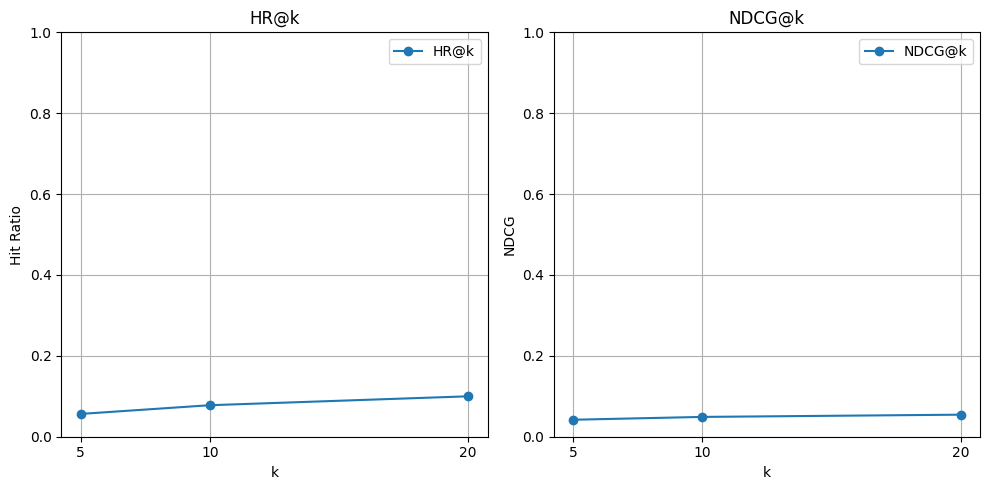

In [ ]:
import matplotlib.pyplot as plt

k_values = [5, 10, 20]
hr_values = [hr[k] for k in k_values]
ndcg_values = [ndcg[k] for k in k_values]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, hr_values, marker='o', label="HR@k")
plt.title("HR@k")
plt.xlabel("k")
plt.ylabel("Hit Ratio")
plt.xticks(k_values)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_values, ndcg_values, marker='o', label="NDCG@k")
plt.title("NDCG@k")
plt.xlabel("k")
plt.ylabel("NDCG")
plt.xticks(k_values)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
